# 3.1 Grundlagen Q-Q Plots

In [1]:
source("util.R")

Hilfsfunktionen

In [2]:
ref_color = "green"
test_color = "blue"

default_theme <- function() {
  theme_jupyter() + theme_squared()
}
two_func_plot <- function(distribution1, func1, color1,
                          distribution2, func2, color2,
                          ival,
                          title = NULL) {
  samples <- seq(ival[1], ival[2], length.out = 100)
  data <- data.frame(x = samples, 
                     values1 = func1(samples), 
                     values2 = func2(samples))
  gg <- ggplot(data) +
        geom_line(aes(x = samples, y = values1, color = "color1"), size=1) +
        geom_line(aes(x = samples, y = values2, color = "color2"), size=1) +
        xlab("x") + ylab("p") +
        scale_color_manual(name = NULL, 
                           values = c("color1" = color1, "color2" = color2), 
                           labels = c(distribution1, distribution2) ) 

  if ( ! is.null(title) ) {
    gg <- gg + ggtitle(title) + theme_centered_title()
  }
  gg + default_theme() + theme(legend.background = element_rect(fill = "white", color = "black"))
}

illustrate_qqplot <- function(test_distribution, test_dfunc, test_pfunc, test_qfunc,
                              ref_distribution = "Standardnormalverteilung", 
                              ref_dfunc = dnorm, 
                              ref_pfunc = pnorm,
                              ref_qfunc = qnorm,
                              ival = c(-3, 3)) {
  samples <- seq(ival[1], ival[2], length.out = 100)

  densities <- two_func_plot(ref_distribution, ref_dfunc, ref_color,
                             test_distribution, test_dfunc, test_color,
                             ival,
                             title = "Dichte") + theme_squared()
  
  cdfs <- two_func_plot(ref_distribution, ref_pfunc, ref_color,
                        test_distribution, test_pfunc, test_color,
                        ival,
                        title = "Verteilung") + theme_squared()
  
  ref_prob  <- ref_pfunc(q = samples)
  test_prob <- test_pfunc(q = samples)
  ref_quantiles <- ref_qfunc(ref_prob)
  test_quantiles <- test_qfunc(ref_prob)
  first_index <- which(test_quantiles > ival[1])[1]
  below_x_high <- which(test_quantiles < ival[2])
  last_index <- below_x_high[length(below_x_high)]
  qq_data <- data.frame(x = ref_quantiles[first_index:last_index], y = test_quantiles[first_index:last_index])
  
  qq_plot <- simple_ggplot(qq_data, NULL, NULL, "black", "QQ-Plot")
  qq_plot <- qq_plot + geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed", size=1)
  qq_plot <- qq_plot + default_theme() 
  qq_plot <- qq_plot + theme(axis.text.x = element_text(color = ref_color),
                             axis.text.y = element_text(color = test_color)) 
  
  densities + cdfs + qq_plot + plot_layout(guides = 'collect') & theme(legend.position = 'right') 
}

## Q-Q Plot t-Verteilung mit schweren Rändern

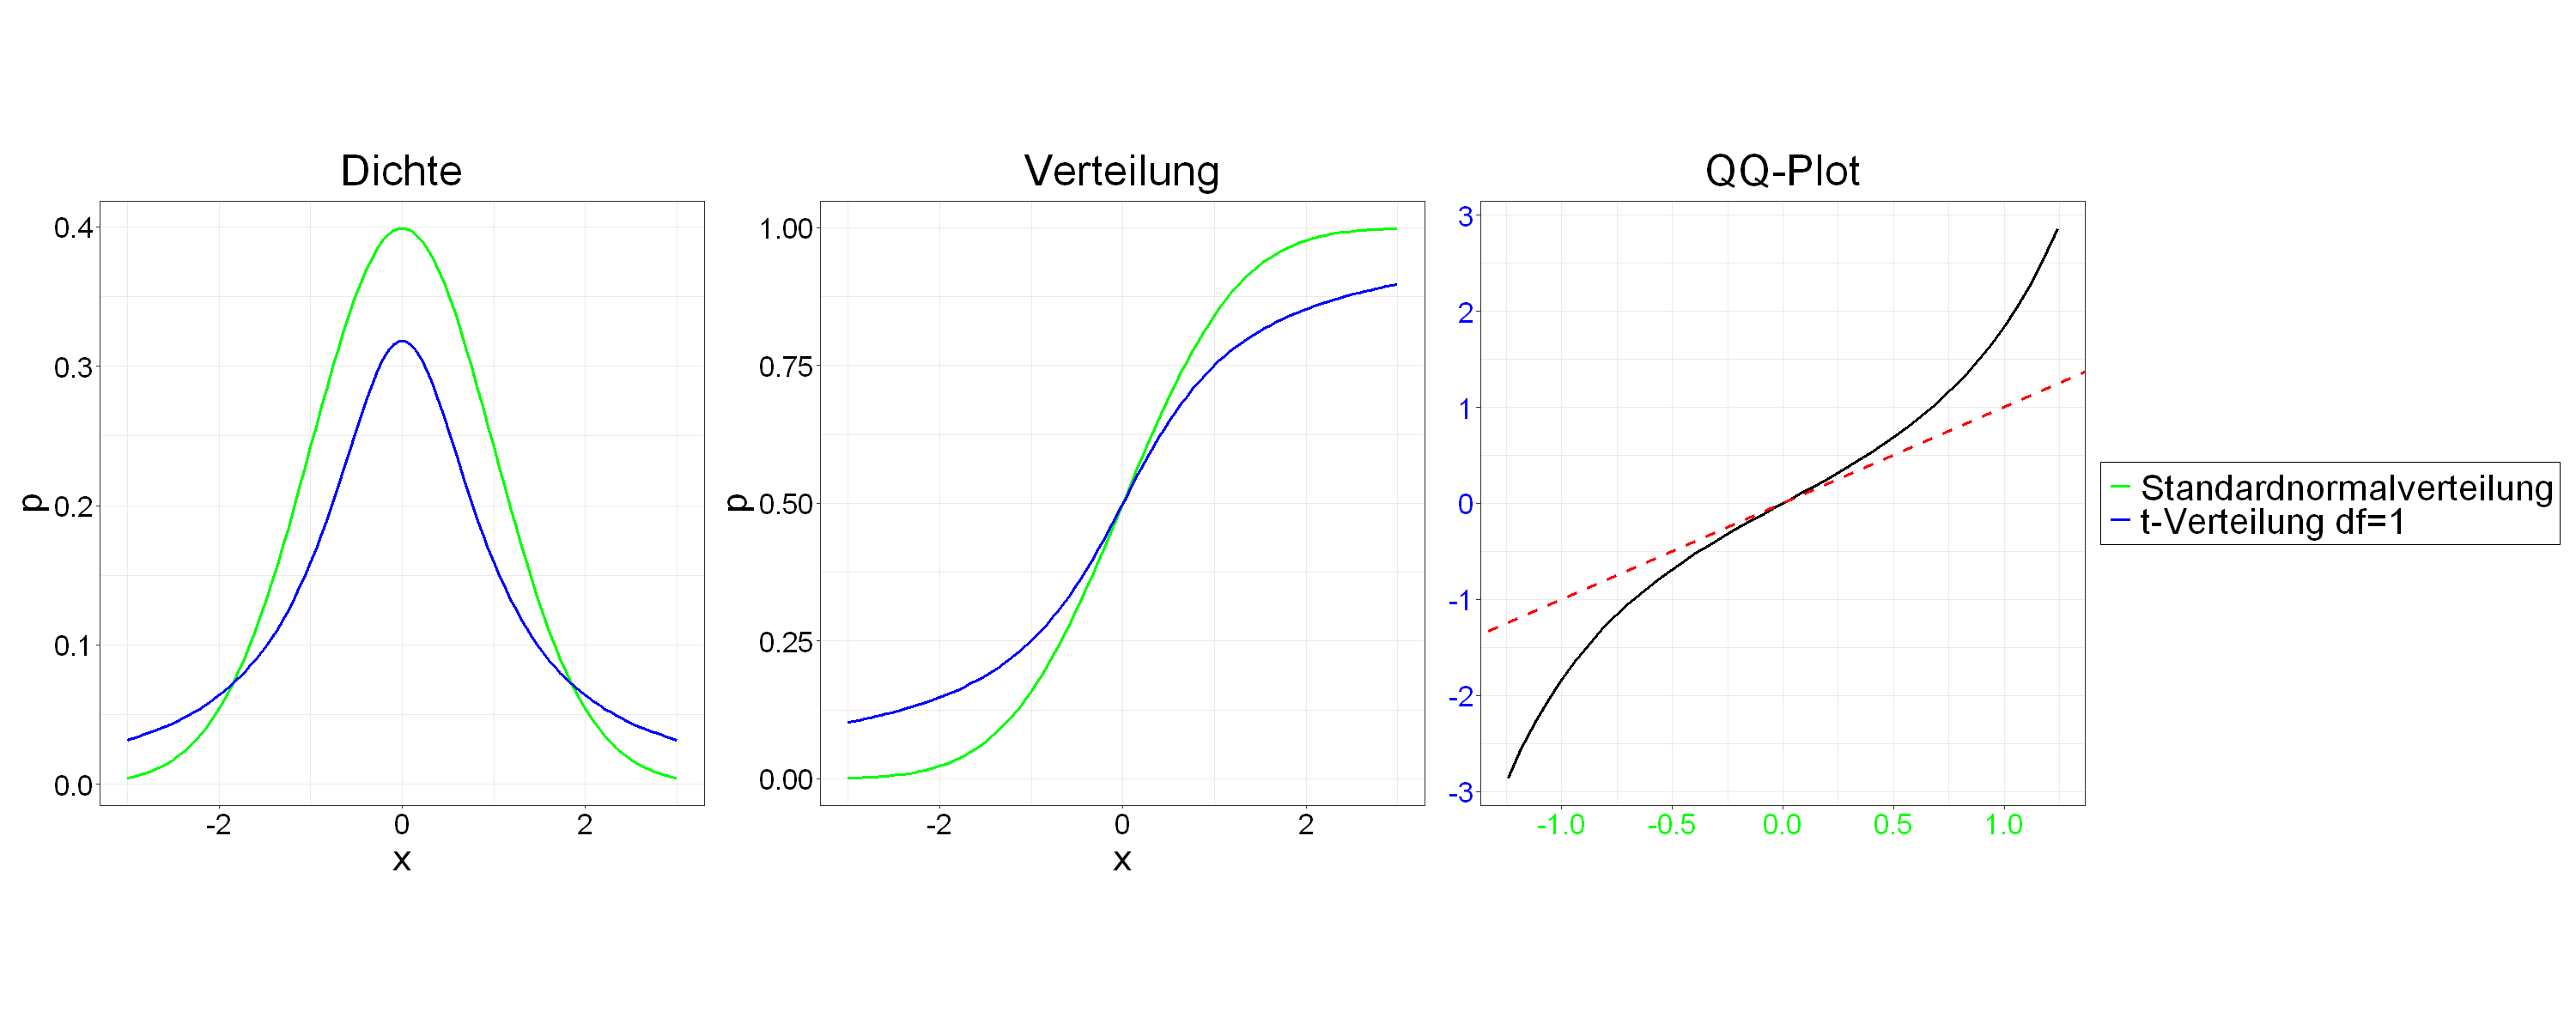

In [3]:
options(repr.plot.width=25, repr.plot.height=10)

df = 1
qqplot_tdist <- illustrate_qqplot(sprintf("t-Verteilung df=%d",df),
                                  partial_func(dt, df=df),
                                  partial_func(pt, df=df),
                                  partial_func(qt, df=df))
print(qqplot_tdist)

## Q-Q Plot Lognormal-Verteilungen

Vergleich zweier Lognormal-Verteilungen mit unterschiedlichen Standardabweichungen

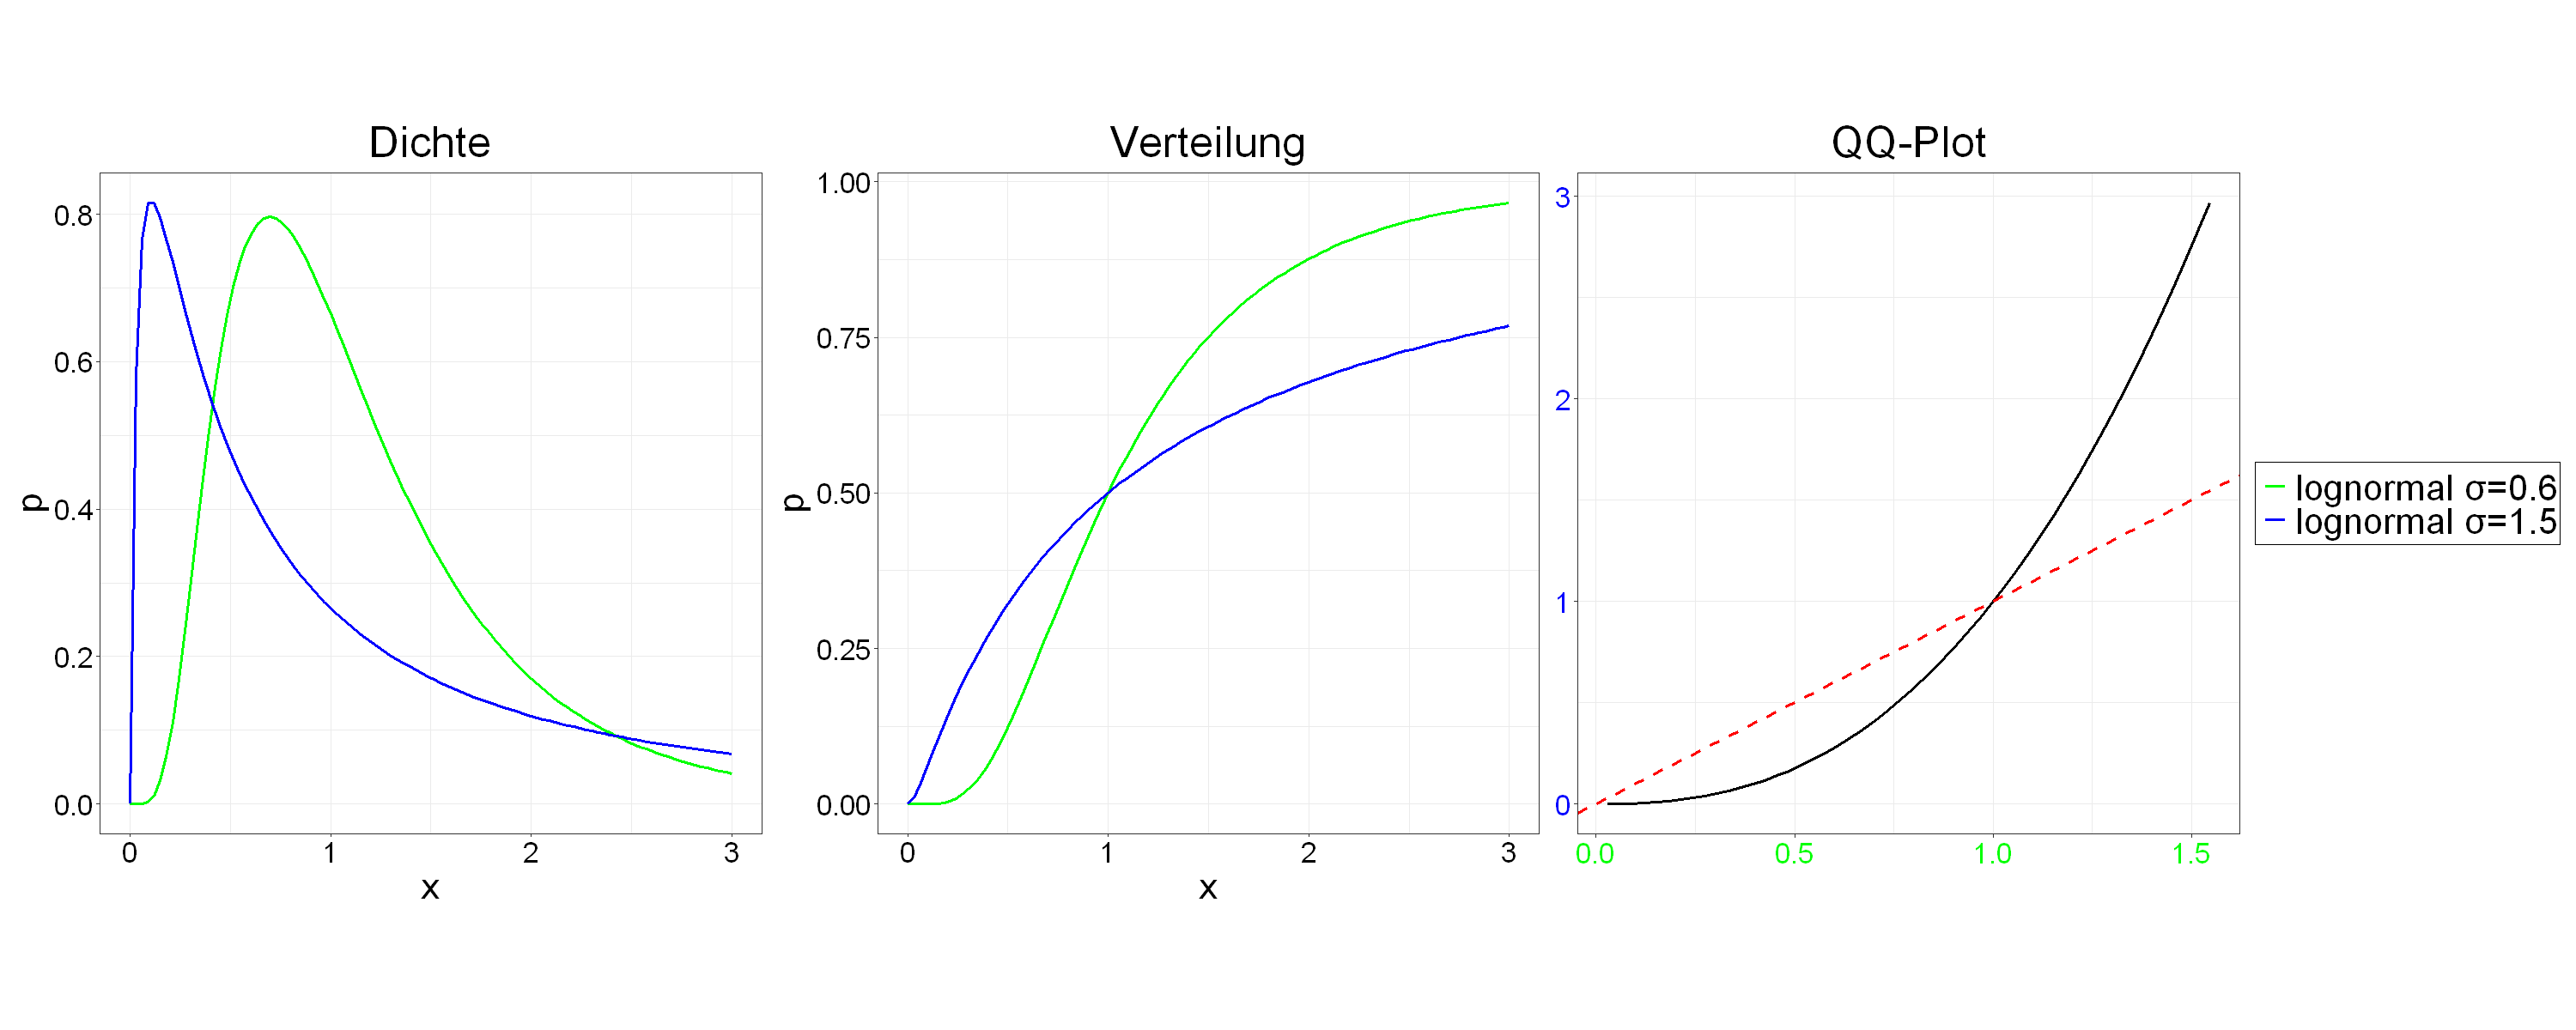

In [4]:
sd1 = 1.5
sd2 = 0.6
qqplot_lognormal <- illustrate_qqplot(sprintf("lognormal σ=%.1f",sd1),
                                      partial_func(dlnorm, sd=sd1),
                                      partial_func(plnorm, sd=sd1),
                                      partial_func(qlnorm, sd=sd1),
                                      sprintf("lognormal σ=%.1f",sd2),
                                      partial_func(dlnorm, sd=sd2),
                                      partial_func(plnorm, sd=sd2),
                                      partial_func(qlnorm, sd=sd2),
                                      c(0,3))
                        
print(qqplot_lognormal)

## Q-Q Plots empirischer Verteilungen

Generische Hilfsfunktion

In [5]:
empirical_qqplot <- function(samples, ref_distribution, ref_dparams, title = NULL) {
  qq <- ggplot(data = data.frame(samples = samples), mapping = aes(sample = samples))
  if (!is.null(title)) {
    qq <- qq + labs(title = title)
  }    
  qq <- qq + stat_qq_point(distribution=ref_distribution, dparams = ref_dparams, size=3)
  qq <- qq + geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed", size=1)
  qq <- qq + xlab(NULL) + ylab(NULL) 
  qq <- qq + theme(axis.text.x = element_text(color = ref_color),
                   axis.text.y = element_text(color = test_color))
  qq
}


### Stichprobe t-Verteilung

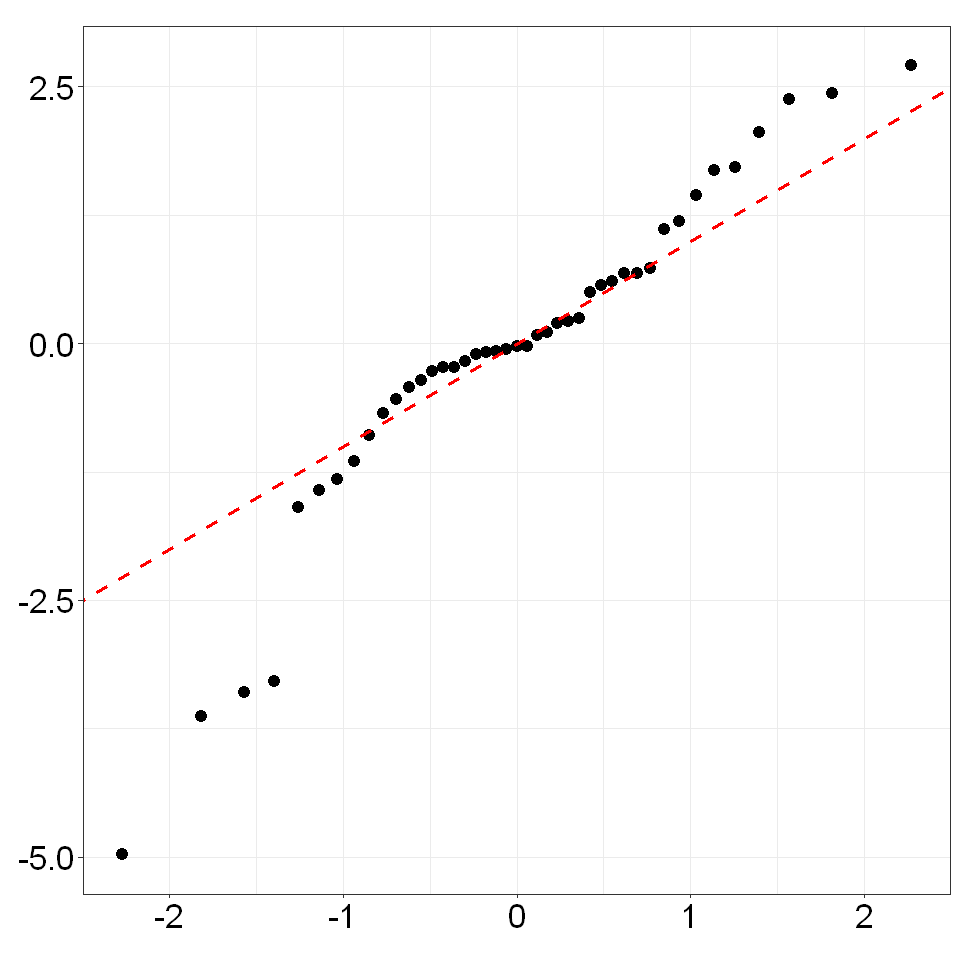

In [6]:
options(repr.plot.width=8, repr.plot.height=8)

set.seed(31)
samples <- rt(50, df = df)
samples <- samples[samples > -5 & samples < 5]
qqplot_empirical_tdist <- empirical_qqplot(samples, "norm", list(mean = 0, sd = 1))
print(qqplot_empirical_tdist + default_theme())

### Stichprobe Log-Normalverteilung

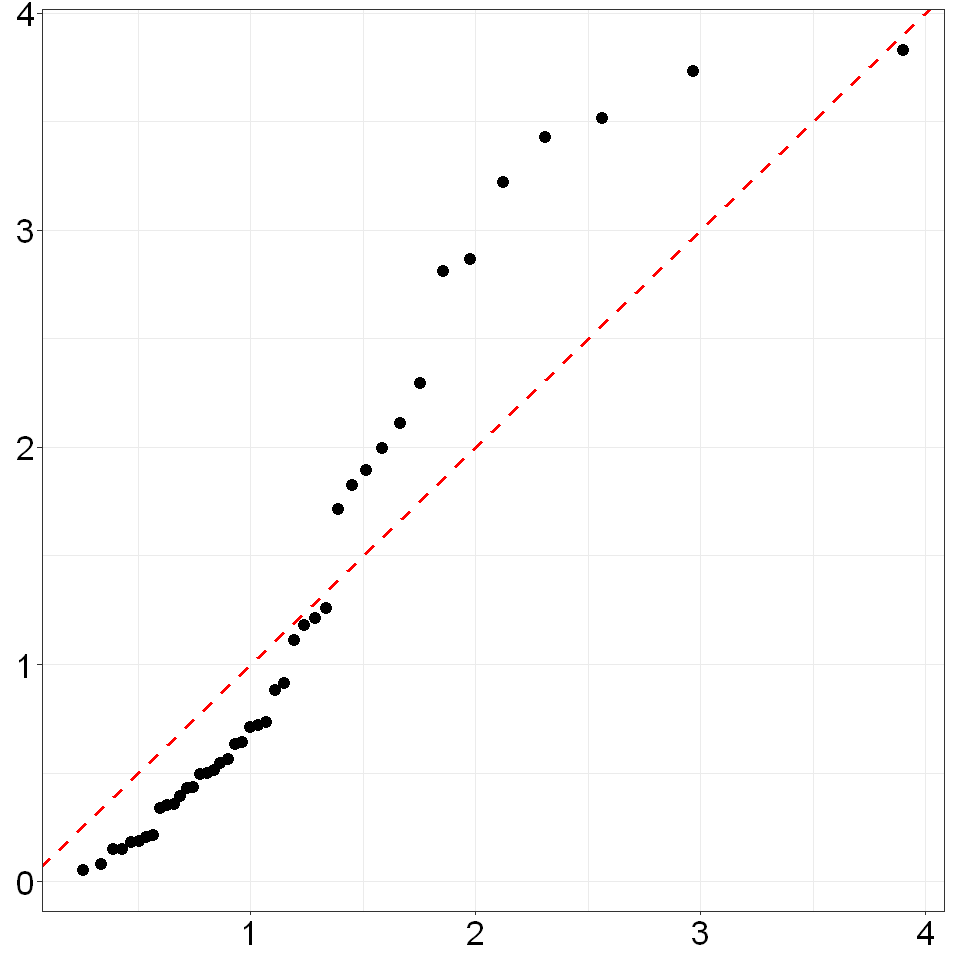

In [7]:
set.seed(123)
samples <- rlnorm(50, sd = sd1)
samples <- samples[samples < 4]
qqplot_empirical_lognormal <- empirical_qqplot(samples, "lnorm", list(sd = sd2))
print(qqplot_empirical_lognormal + default_theme())

## Wahrscheinlichkeitspapier

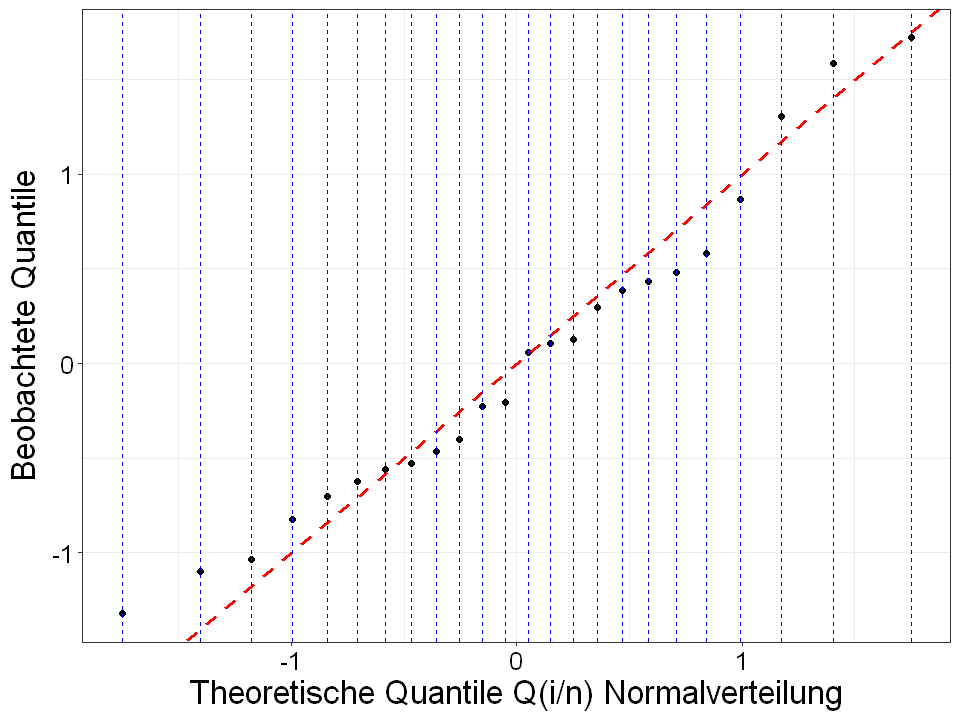

In [12]:
options(repr.plot.width=8, repr.plot.height=6)

n=25
inc = 1.0/n
probabilities <- seq(inc, 1-inc, by = inc)
theoretical_quantiles <- qnorm(probabilities)

set.seed(123)
data <- data.frame(samples = rnorm(length(probabilities)))
sample_quantiles <- quantile(data$samples, probabilities)

prob_paper <- ggplot(data, aes(x = theoretical_quantiles, y = sample_quantiles)) +
  geom_point() +
  geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed", size = 1) +
  xlab("Theoretische Quantile Q(i/n) Normalverteilung") +
  ylab("Beobachtete Quantile")

for (q in theoretical_quantiles) {
  prob_paper <- prob_paper + geom_vline(xintercept = q, linetype = "dashed", color = "blue")
}  

print(prob_paper + theme_jupyter(axis_title_size=20))